In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from growth.sweep.sweep import Sweep
from clones.validation.sweep import SweepBenchmark
%matplotlib inline

In [2]:
ls ../synthetic/

Sweep_181201_191409/          Sweep_181201_191516_twolevel/
Sweep_181201_191516/          Sweep_181201_191521/
Sweep_181201_191516_new/      build_sweep.py


# load sweep results

In [3]:
sweep_path = '../synthetic/Sweep_181201_191516_twolevel/'
sweep = Sweep.load(sweep_path)
sweep

1 x 16 sweep, 4 recombination generations

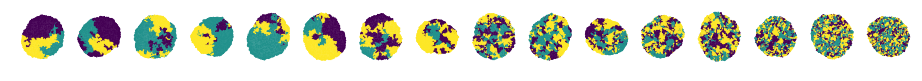

In [4]:
# plot single replicate for each batch
fig = sweep.plot_culture_grid(replicate_id=0, s=2)

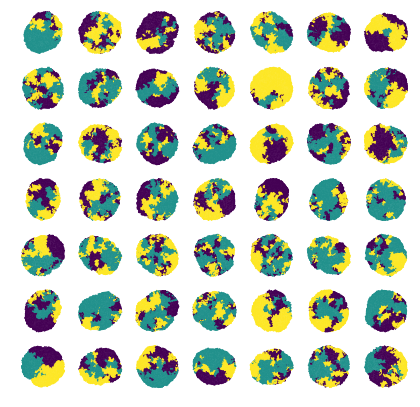

In [5]:
# plot all replicates for a single batch
fig = sweep.batches[0, 4].plot_culture_grid()

# load benchmarking results

In [4]:
benchmark = SweepBenchmark.load(sweep_path)

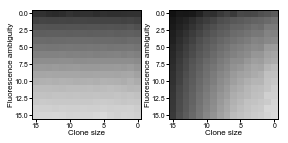

In [5]:
fig = benchmark.results.plot_absolute_error(log=True)

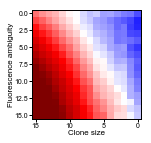

In [8]:
fig = benchmark.results.plot_relative_error()

In [9]:
benchmark.results.data.community.max()

0.22168841054601207

In [19]:
from matplotlib.colors import Normalize

vmax = np.percentile(benchmark.load_benchmark(0, benchmark.num_scales-1).classifier.values, 99)
norm = Normalize(vmin=0, vmax=vmax)

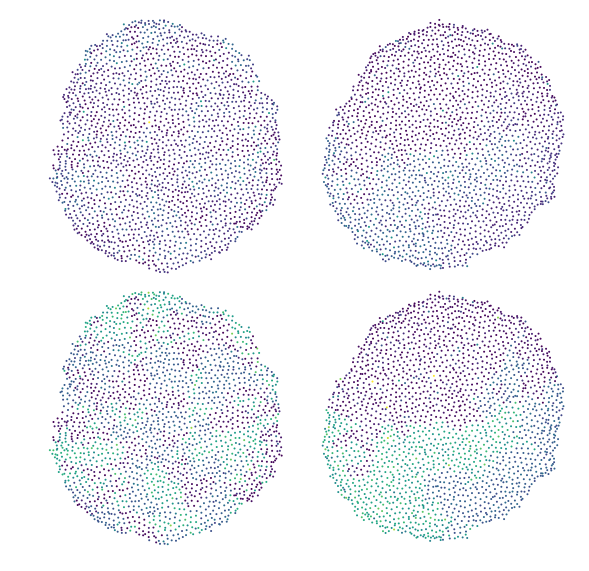

In [21]:
fig = benchmark.plot_fluorescence(resolution=8, s=4, figsize=(10, 10), cmap=plt.cm.viridis, norm=norm)

In [5]:
batch_id, scale_id = 5, 4
batch_benchmark = benchmark.load_benchmark(batch_id, scale_id)

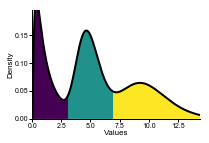

In [6]:
batch_benchmark.classifier.plot_pdf()

In [8]:
batch_benchmark.logratio = False
simulation_benchmark = batch_benchmark.benchmark_simulation(0)

In [16]:
score = simulation_benchmark.scores['community']

In [131]:
batch_benchmark.logratio = True
simulation_benchmark = batch_benchmark.benchmark_simulation(0)
scores, df, labels = katz_annotation(simulation_benchmark.annotator, gamma=1., alpha=0.9)

print('INFOMAP:', simulation_benchmark.community_MAE)
print('KATZ:', scores.MAE)

INFOMAP: 0.02837985585098972
KATZ: 0.011642373876169669


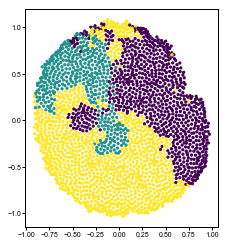

In [127]:
fig, ax = plt.subplots()
ax.scatter(*df[['centroid_x', 'centroid_y']].values.T, c=labels, s=5)
ax.set_aspect(1)

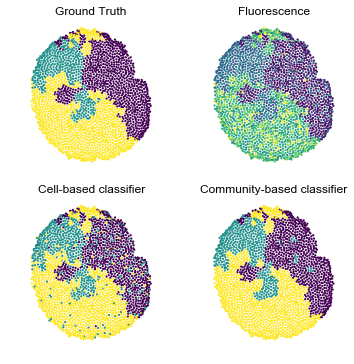

In [117]:
simulation_benchmark.show()

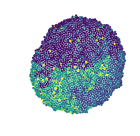

In [18]:
simulation_benchmark.plot_measurements(s=5)

In [146]:
batch_benchmark.logratio = True
simulation_benchmark = batch_benchmark.benchmark_simulation(0)
scores, df, labels = katz_annotation(simulation_benchmark.annotator, alpha=0.9)

print('INFOMAP:', simulation_benchmark.community_MAE)
print('KATZ:', scores.MAE)

INFOMAP: 0.015196544503706439
KATZ: 0.009694592946973647


In [147]:
import networkx as nx
from copy import deepcopy
from clones.validation.scoring import Scoring


def katz_annotation(annotator, alpha=0.9, beta=1.):
    """
    Katz centrality applied to undirected edges weighted by node similarity.
    """

    # build undirected graph weighted by node similarity
    G = nx.Graph()
    G.add_weighted_edges_from(annotator.graph.build_links())
    degree = np.vectorize(G.degree)(G.nodes)

    graph_df = annotator.graph.df.loc[list(G.nodes)]

    ground_truth_genotype = graph_df.ground.values
    node_posterior = annotator.cell_classifier.evaluate_posterior(graph_df)
    posterior = deepcopy(node_posterior.T)
    previous_genotype = posterior.argmax(axis=0)

    adjacency = nx.to_numpy_array(G)
    adjacency /= adjacency.sum(axis=0)

    n = np.array(adjacency).shape[0]
    centrality = np.linalg.solve(np.eye(n, n)-(alpha*adjacency), beta*posterior.T)

    new_genotypes = centrality.argmax(axis=1)

    new_scores = Scoring(ground_truth_genotype, new_genotypes)

    return new_scores, graph_df, new_genotypes

NameError: name 'ErrorColorbar' is not defined

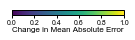

In [19]:
from growth.visualization.colorbars import ColorBar, ErrorColorBar
cbar = ColorBar(label='Change in Mean Absolute Error')
ebar = ErrorColorbar(vlim=(-8, 8), label='Fold-change in Mean Absolute Error')

In [ ]:
edges

In [92]:
edges = simulation_benchmark.annotator.graph.edges
x = simulation_benchmark.annotator.graph.df.fluorescence

def get_weights(edges, log=False):
    if log:
        get_difference = lambda i,j: np.abs(np.log((x.loc[i]/x.loc[j])))
    else:
        get_difference = lambda i,j: np.abs(x.loc[i] - x.loc[j])
    
    energy = np.array([get_difference(*e) for e in edges])
    weights = np.exp(-energy/np.mean(energy))
    return weights

weights_log = get_weights(edges, log=True)
weights = get_weights(edges, log=False)

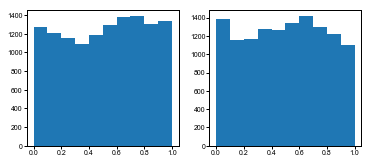

In [93]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(6, 2.5))
_ = ax0.hist(weights, bins=10)
_ = ax1.hist(weights_log, bins=10)

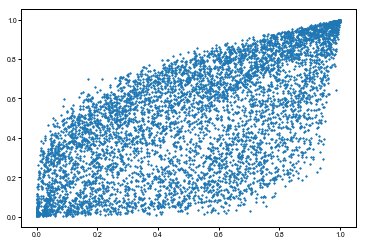

In [95]:
fig, ax = plt.subplots()
ax.scatter(weights, weights_log, s=1)

In [25]:
edges = simulation_benchmark.annotator.graph.build_links()

In [54]:
edges = simulation_benchmark.annotator.graph.edges
weights = simulation_benchmark.annotator.graph.evaluate_edge_weights('fluorescence')

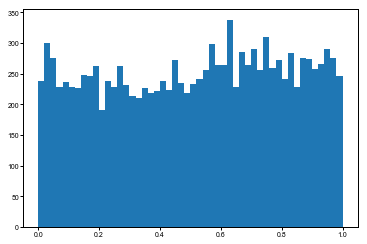

In [55]:
_ = plt.hist(weights, bins=50)

In [44]:
np.unique(np.sort(edges, axis=1), axis=0).shape

(6311, 2)

In [45]:
weights.shape

(12615,)